In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE

In [2]:
# 读取CSV文件
df = pd.read_csv('cleaned_charging_station_data.csv')
df = df.reset_index(drop=True)
# 显示数据的基本信息

C:\Users\colin\AppData\Local\Temp\ipykernel_2704\4140120779.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_charging_station_data.csv')


In [3]:
df = df.drop(['is_weekend', 'time_of_day', 'is_holiday','is_work_hour','connector_unique_id','usage_last_24h','usage_last_7d','city_density_level','availability_24h_ago','availability_1week_ago','availability_change','relative_days'], axis=1)

In [4]:

# 假设您的数据框架名为df

# 对station_name进行编码
station_encoder = LabelEncoder()
df['station_name_encoded'] = station_encoder.fit_transform(df['station_name'].astype(str))

# 保存station_encoder
joblib.dump(station_encoder, 'station_encoder.joblib')

# 对city_id进行编码
city_encoder = LabelEncoder()
df['city_id_encoded'] = city_encoder.fit_transform(df['city_id'].astype(str))

# 保存city_encoder
joblib.dump(city_encoder, 'city_encoder.joblib')

# 删除原始列
df = df.drop(['station_name', 'city_id'], axis=1)

In [5]:
# 假设你的数据框名为 df
X = df.drop('is_available', axis=1)
y = df['is_available']

In [6]:

# 创建周期性特征
X['hour_sin'] = np.sin(X['hour'] * (2 * np.pi / 24))
X['hour_cos'] = np.cos(X['hour'] * (2 * np.pi / 24))
X['day_of_week_sin'] = np.sin(X['day_of_week'] * (2 * np.pi / 7))
X['day_of_week_cos'] = np.cos(X['day_of_week'] * (2 * np.pi / 7))
X = X.drop('hour', axis=1)
X = X.drop('day_of_week', axis=1)

In [7]:

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:


# 假设 X 和 y 已经准备好

# 初始化随机森林分类器
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# 训练模型
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [9]:


# 在测试集上进行预测
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

# 打印分类报告
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 打印混淆矩阵
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# 计算 AUC-ROC 分数
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC-ROC Score: {auc_roc:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.65      0.69    331658
           1       0.88      0.92      0.90    919460

    accuracy                           0.85   1251118
   macro avg       0.82      0.78      0.80   1251118
weighted avg       0.85      0.85      0.85   1251118


Confusion Matrix:
[[213931 117727]
 [ 70118 849342]]

AUC-ROC Score: 0.8767



Cross-validation AUC-ROC Scores: [0.50912894 0.20200121 0.15320303 0.44776379 0.80747978]
Mean CV AUC-ROC Score: 0.4239


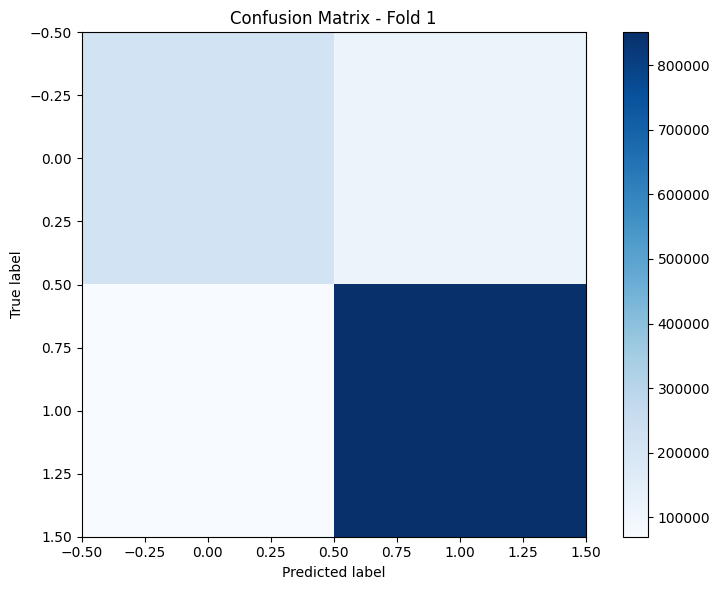

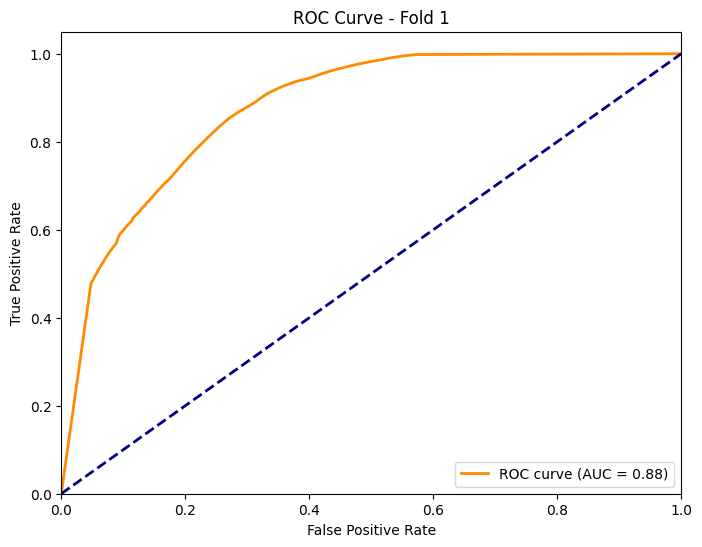

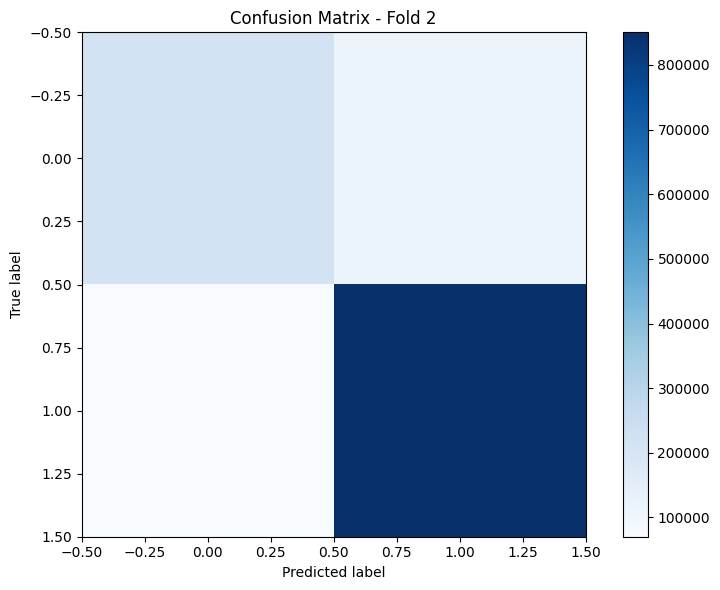

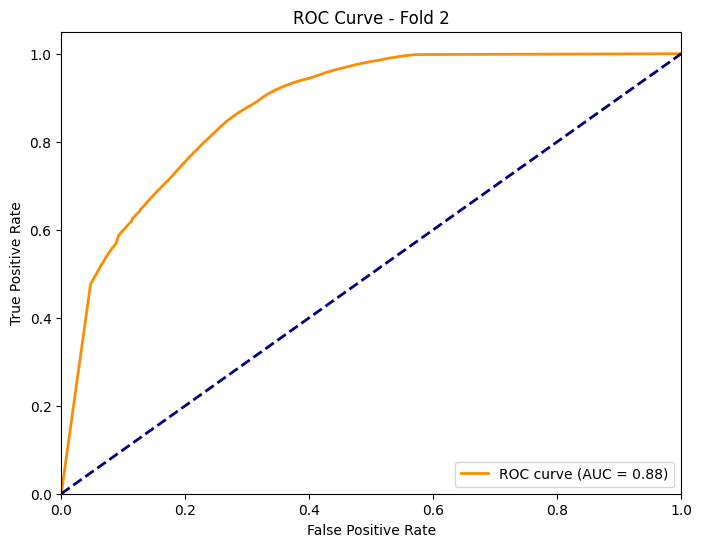

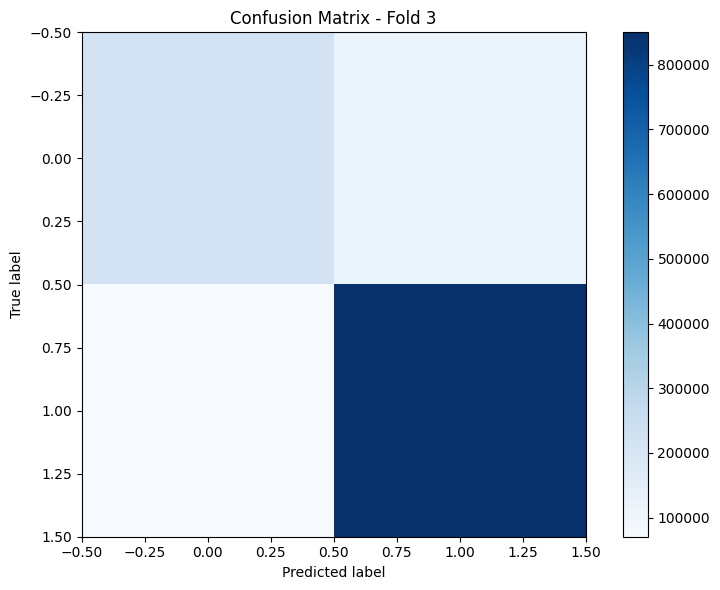

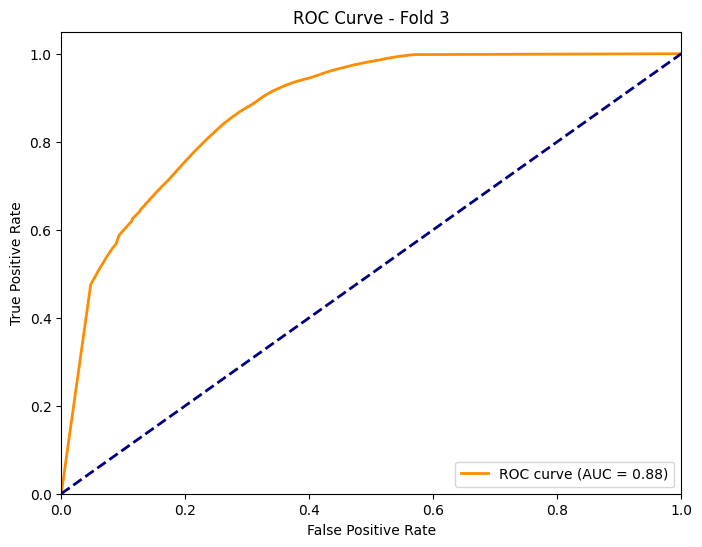

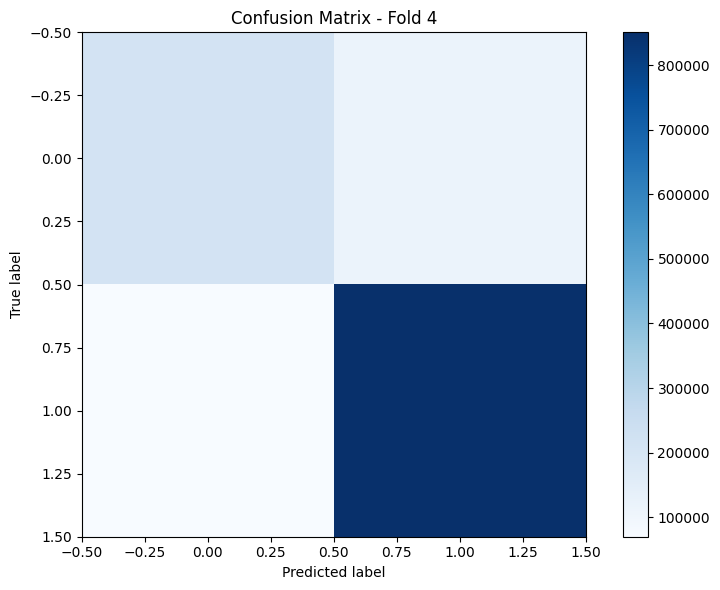

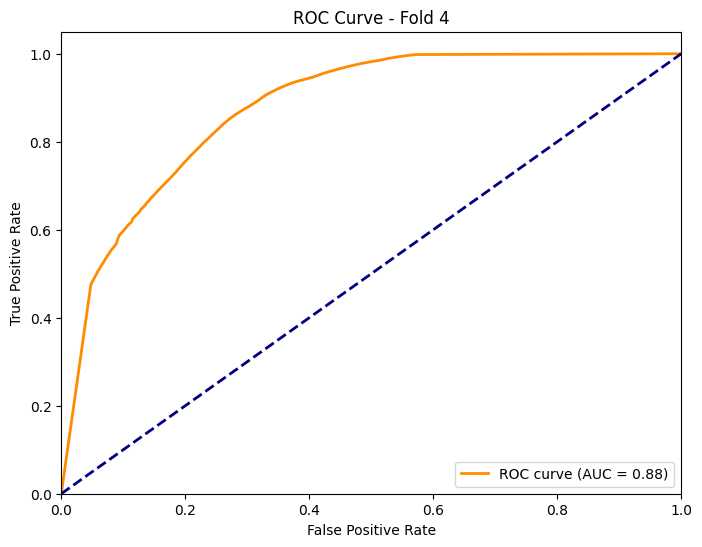

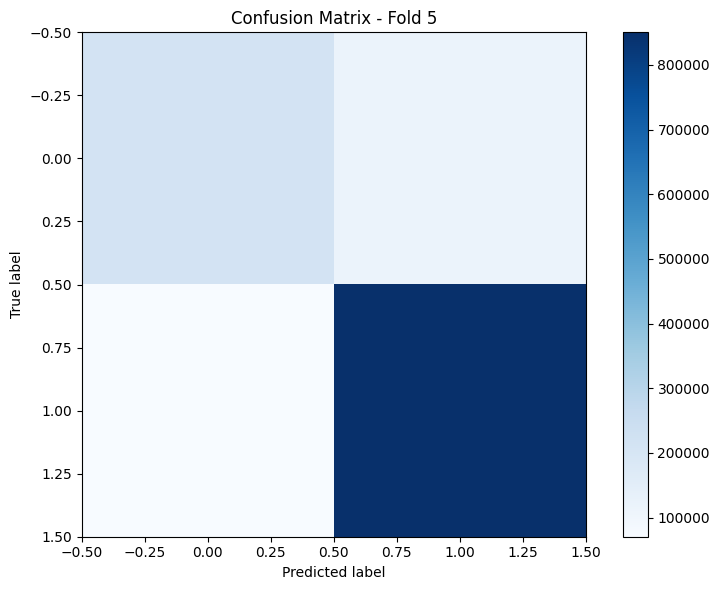

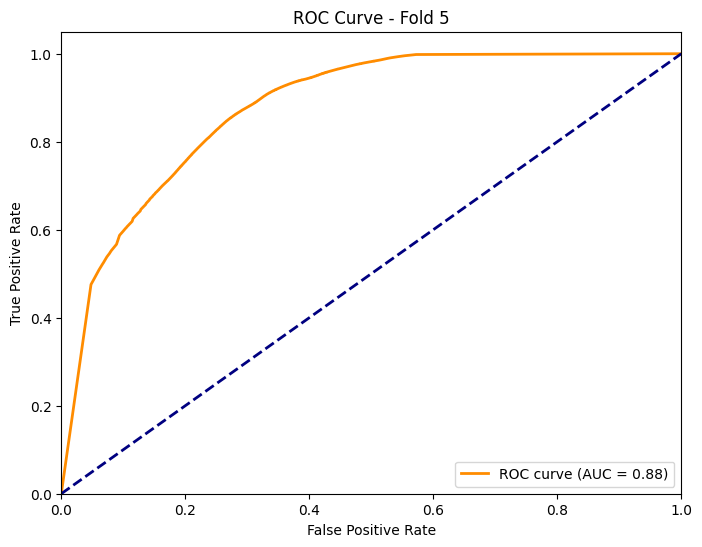

Stratified CV AUC-ROC Scores: [np.float64(0.8772601261772898), np.float64(0.8770574560932674), np.float64(0.8770307464005669), np.float64(0.8767656974995741), np.float64(0.8768218507852539)]
Mean Stratified CV AUC-ROC Score: 0.8770


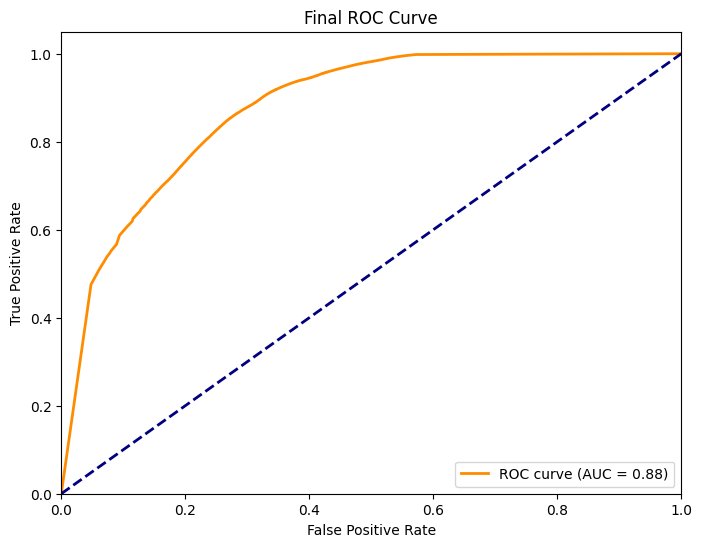

In [9]:


# 进行交叉验证
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')
print(f"\nCross-validation AUC-ROC Scores: {cv_scores}")
print(f"Mean CV AUC-ROC Score: {cv_scores.mean():.4f}")

# 使用分层交叉验证
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
stratified_cv_scores = []

for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    y_pred_proba = rf.predict_proba(X_test)[:, 1]
    
    # 计算并存储 AUC-ROC 分数
    fold_auc_roc = roc_auc_score(y_test, y_pred_proba)
    stratified_cv_scores.append(fold_auc_roc)
    
    # 绘制混淆矩阵
    plt.figure(figsize=(8,6))
    cm = confusion_matrix(y_test, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.colorbar()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()
    
    # 绘制 ROC 曲线
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Fold {fold}')
    plt.legend(loc="lower right")
    plt.show()

print("Stratified CV AUC-ROC Scores:", stratified_cv_scores)
print(f"Mean Stratified CV AUC-ROC Score: {np.mean(stratified_cv_scores):.4f}")

# 绘制最终的 ROC 曲线（使用全部测试集）
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [10]:
# 获取特征重要性
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Top 10 Most Important Features:
                feature  importance
0   connector_avg_usage    0.335831
1     station_avg_usage    0.275176
2              hour_sin    0.079776
3              hour_cos    0.077018
4       day_of_week_sin    0.059567
5       day_of_week_cos    0.033323
6  station_name_encoded    0.018933
7          connector_id    0.012468
8        weather_Clouds    0.011215
9         coordinates_x    0.009725


ValueError: Found input variables with inconsistent numbers of samples: [1321964, 1841253]

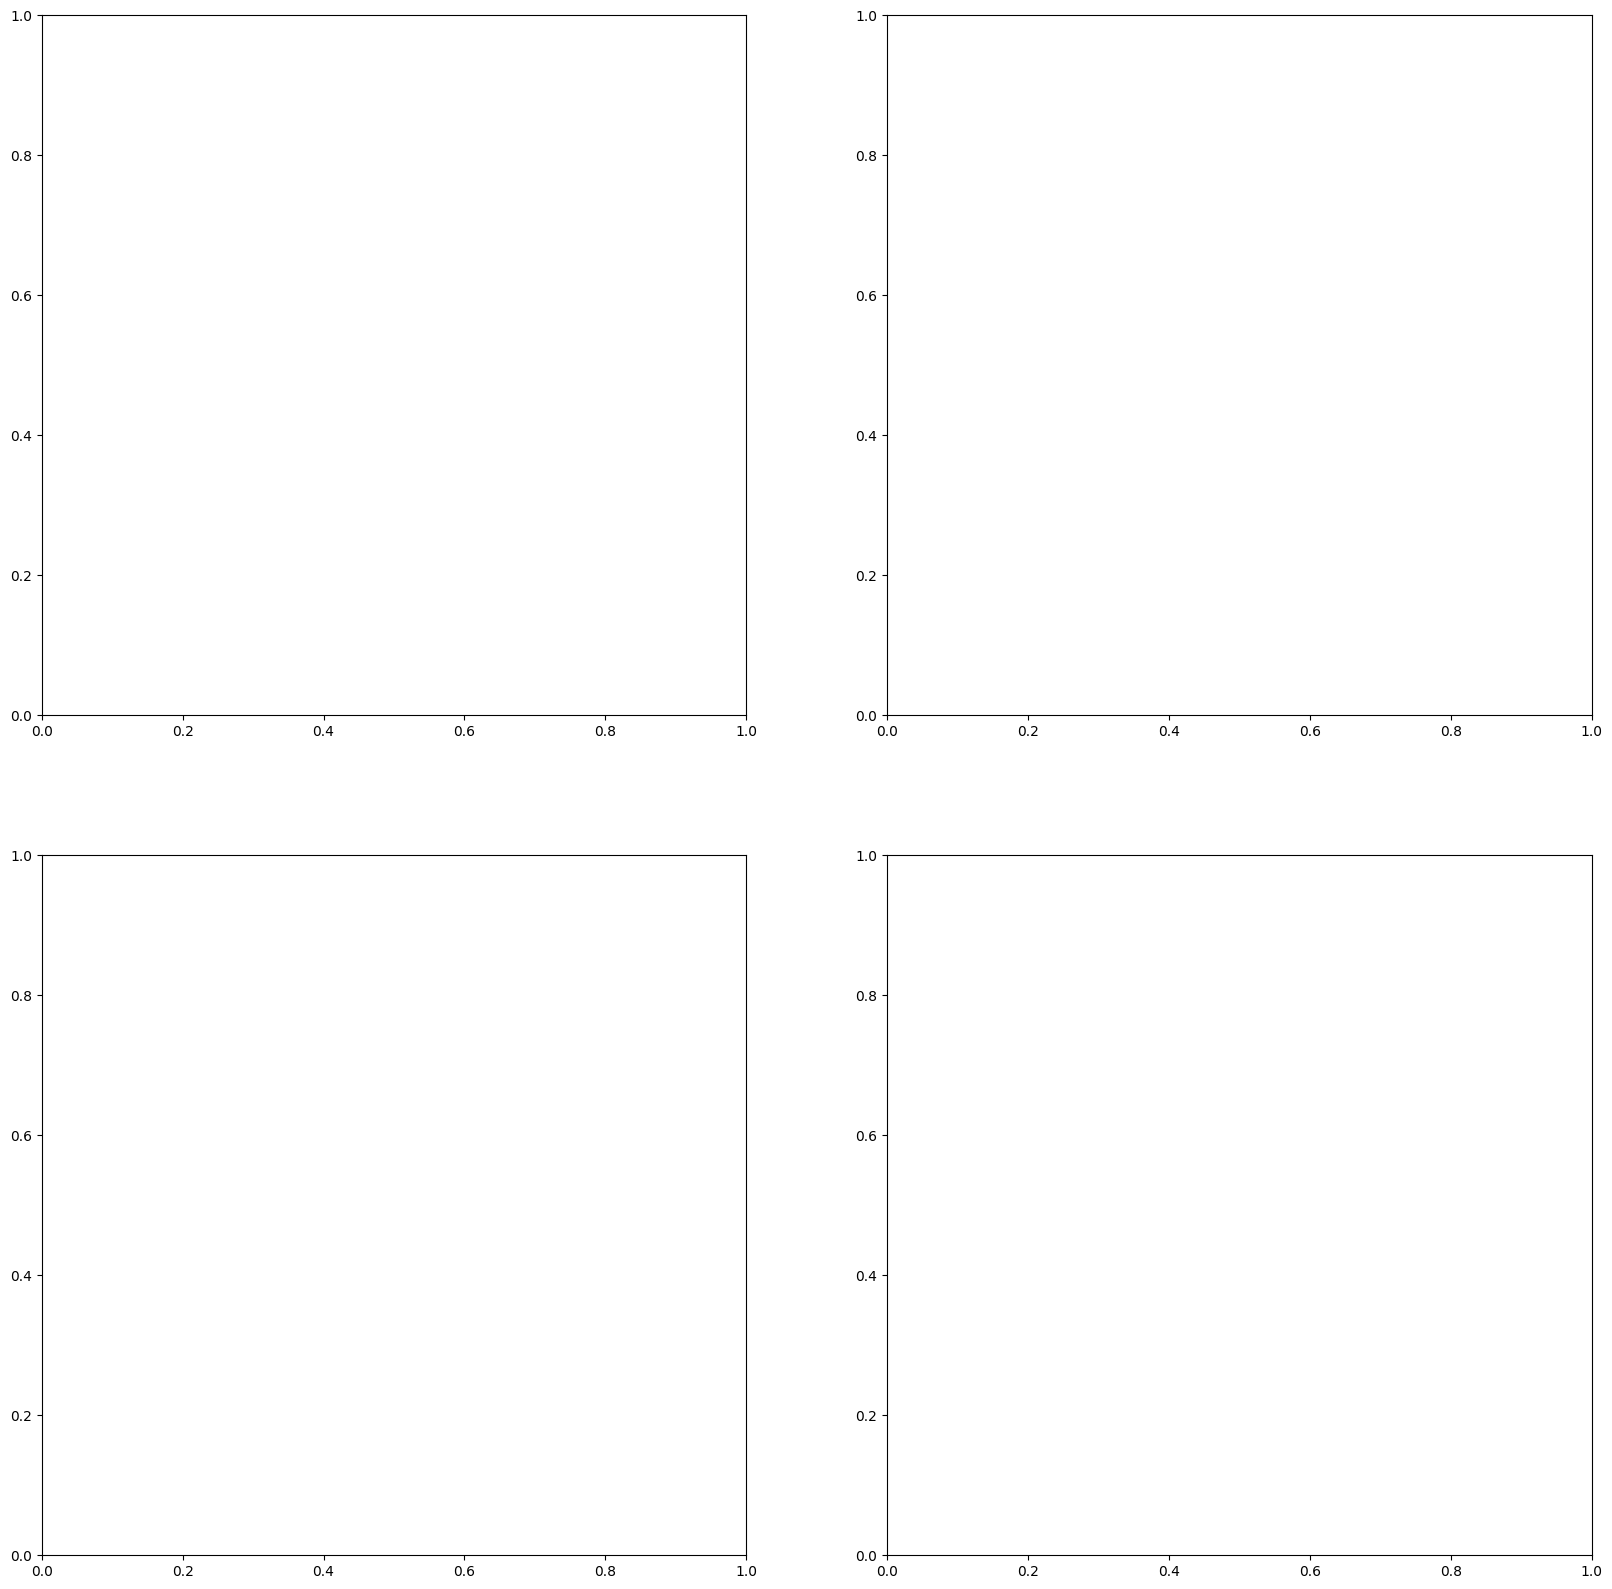

In [22]:
# 创建一个2x2的子图布局
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 20))

# 1. 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
im = ax1.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax1.set_title('Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax1.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")
fig.colorbar(im, ax=ax1)

# 2. ROC曲线
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
ax2.legend(loc="lower right")

# 3. 特征重要性
feature_importance.sort_values('importance', ascending=True).plot(kind='barh', x='feature', y='importance', ax=ax3)
ax3.set_title('Feature Importance')
ax3.set_xlabel('Importance')

# 4. 预测概率分布
ax4.hist(y_pred_proba, bins=50, edgecolor='black')
ax4.set_title('Distribution of Predicted Probabilities')
ax4.set_xlabel('Predicted Probability')
ax4.set_ylabel('Count')

plt.tight_layout()
plt.show()

In [12]:


# 假设 X 和 y 已经准备好

# 处理类别不平衡
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 初始化随机森林分类器，调整参数
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,  # 限制树的深度
    min_samples_leaf=5,  # 增加叶子节点的最小样本数
    max_features='sqrt',  # 使用特征的平方根作为每个节点的最大特征数
    random_state=42,
    n_jobs=-1
)

# 训练模型
rf.fit(X_train, y_train)

# 使用概率校准
calibrated_rf = CalibratedClassifierCV(rf, method='sigmoid', cv=5)
calibrated_rf.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = calibrated_rf.predict(X_test)
y_pred_proba = calibrated_rf.predict_proba(X_test)[:, 1]

# 打印分类报告
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 打印混淆矩阵
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# 计算 AUC-ROC 分数
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC-ROC Score: {auc_roc:.4f}")



Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82    920800
           1       0.80      0.87      0.83    920453

    accuracy                           0.83   1841253
   macro avg       0.83      0.83      0.83   1841253
weighted avg       0.83      0.83      0.83   1841253


Confusion Matrix:
[[718631 202169]
 [118086 802367]]

AUC-ROC Score: 0.9152


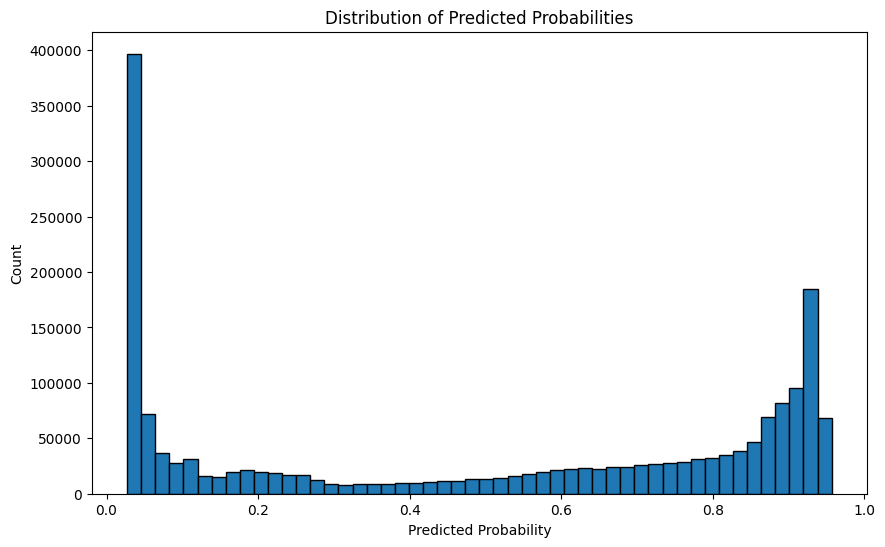

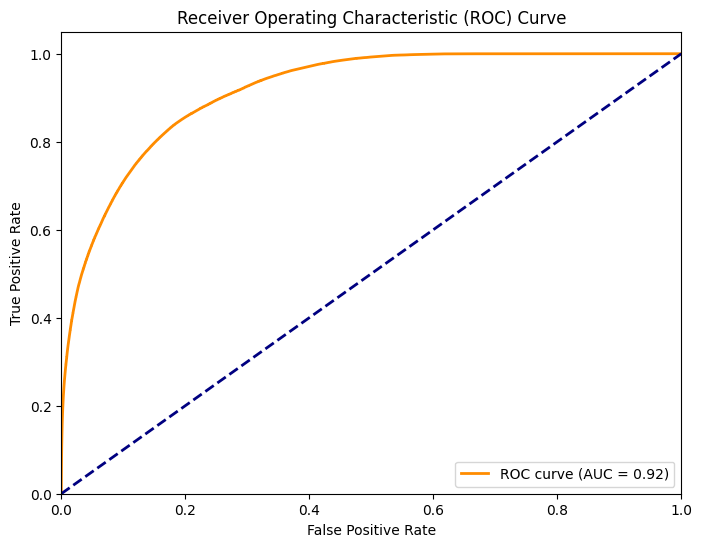

In [13]:
# 绘制预测概率分布图
plt.figure(figsize=(10, 6))
plt.hist(y_pred_proba, bins=50, edgecolor='black')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.show()

# 绘制 ROC 曲线
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import ColumnTransformer
# 假设 X 和 y 已经准备好

features_to_scale = [
    'coordinates_x', 
    'coordinates_y', 
    'tariff_amount', 
    'tariff_connectionfee',
    'max_chargerate',
    'connector_avg_usage', 
    'station_avg_usage', 
    'distance_to_center', 
    'city_station_density', 
    'station_connector_count',
    'station_avg_max_chargerate',
    'station_density_10km', 
    'station_density_1km', 
    'station_density_20km'
]

# 获取不需要标准化的特征
features_to_pass = [col for col in X.columns if col not in features_to_scale]

# 创建 ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_to_scale),
        ('pass', 'passthrough', features_to_pass)
    ])

# 使用 preprocessor 处理数据
X_processed = preprocessor.fit_transform(X)

# 创建新的 DataFrame，保持列名
X_scaled = pd.DataFrame(X_processed, columns=features_to_scale + features_to_pass)

In [15]:


# 欠采样多数类，然后对少数类进行SMOTE
undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_under, y_under = undersampler.fit_resample(X_scaled, y)
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_under, y_under)

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 创建多个模型
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,  # 限制树的深度
    min_samples_leaf=5,  # 增加叶子节点的最小样本数
    max_features='sqrt',  # 使用特征的平方根作为每个节点的最大特征数
    random_state=42,
    n_jobs=-1
)
gb = GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)

In [16]:

# 使用概率校准
calibrated_rf = CalibratedClassifierCV(rf, method='isotonic', cv=5)
calibrated_gb = CalibratedClassifierCV(gb, method='isotonic', cv=5)

# 训练模型
calibrated_rf.fit(X_train, y_train)
calibrated_gb.fit(X_train, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=GradientBoostingClassifier(max_depth=5,
                                                            random_state=42),
                       method='isotonic')

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86    660861
           1       0.85      0.88      0.86    661103

    accuracy                           0.86   1321964
   macro avg       0.86      0.86      0.86   1321964
weighted avg       0.86      0.86      0.86   1321964


AUC-ROC Score: 0.9369


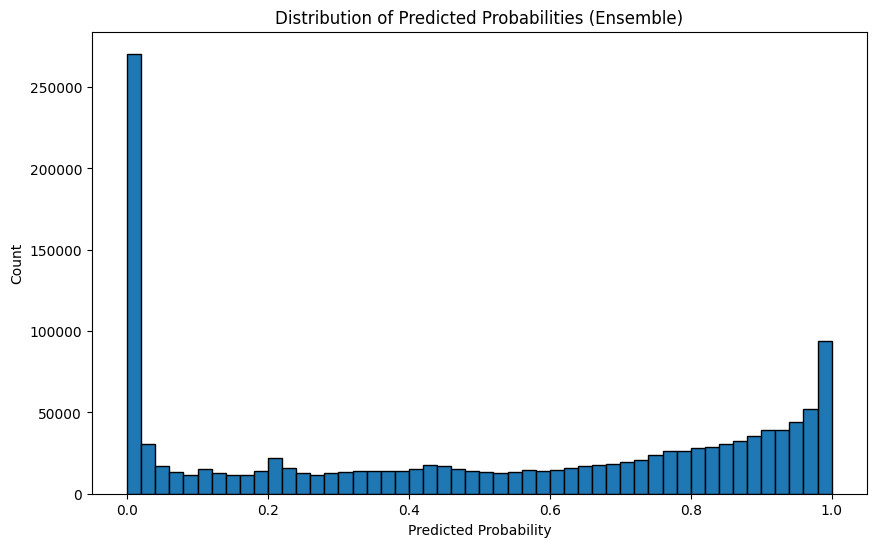

In [17]:
# 在测试集上进行预测
y_pred_rf = calibrated_rf.predict_proba(X_test)[:, 1]
y_pred_gb = calibrated_gb.predict_proba(X_test)[:, 1]

# 集成预测
y_pred_ensemble = (y_pred_rf + y_pred_gb) / 2

# 打印分类报告
y_pred_class = (y_pred_ensemble > 0.5).astype(int)
print("Classification Report:")
print(classification_report(y_test, y_pred_class))

# 计算 AUC-ROC 分数
auc_roc = roc_auc_score(y_test, y_pred_ensemble)
print(f"\nAUC-ROC Score: {auc_roc:.4f}")

# 绘制混淆矩阵
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred_ensemble_class)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()


# 绘制 ROC 曲线
fpr, tpr, _ = roc_curve(y_test, y_pred_ensemble)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# 绘制预测概率分布图
plt.figure(figsize=(10, 6))
plt.hist(y_pred_ensemble, bins=50, edgecolor='black')
plt.title('Distribution of Predicted Probabilities (Ensemble)')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.show()